# Structure from Motion (SfM) Notebook

This notebook demonstrates how to generate a 3D point cloud from a set of images using Structure from Motion (SfM) techniques.
We'll use OpenCV for feature extraction, matching, and triangulation.
Ensure you have the necessary images in the specified directory.


In [1]:
import cv2
import numpy as np
import os
import glob
from matplotlib import pyplot as plt

# Set paths
data_in = "data"
data_set = "globe"
data_out = "out"

# Create output directory if it doesn't exist
os.makedirs(data_out, exist_ok=True)

## Step 1: Feature Extraction and Matching


In [2]:
def get_original_image_id(id):
    return 31 - id if id < 16 else id - 16

In [3]:
# Load images
image_paths = sorted(glob.glob(os.path.join(data_in, data_set, "*.JPG")))
images = [cv2.imread(img_path, cv2.IMREAD_COLOR_RGB) for img_path in image_paths]
# Rearrange in this order (index): from 31 to 16 then 0 to 15
images = images[31:15:-1] + images[0:16]


# Initialize SIFT detector
sift = cv2.SIFT_create()

# Extract features and match them
keypoints = []
descriptors = []
for img in images:
    kp, des = sift.detectAndCompute(img, None)
    keypoints.append(kp)
    descriptors.append(des)

# Match features between images
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = {}
for i in range(len(images) - 1):
    matches[(i, i + 1)] = bf.match(descriptors[i], descriptors[i + 1])
    print(
        f"Number of matches between images {get_original_image_id(i)} and {get_original_image_id(i + 1)}: {len(matches[(i, i + 1)])}"
    )

# Sort matches by distance
matches = {k: sorted(v, key=lambda x: x.distance) for k, v in matches.items()}

Number of matches between images 31 and 30: 776
Number of matches between images 30 and 29: 994
Number of matches between images 29 and 28: 1105
Number of matches between images 28 and 27: 875
Number of matches between images 27 and 26: 1581
Number of matches between images 26 and 25: 1869
Number of matches between images 25 and 24: 1313
Number of matches between images 24 and 23: 1507
Number of matches between images 23 and 22: 1633
Number of matches between images 22 and 21: 1232
Number of matches between images 21 and 20: 1082
Number of matches between images 20 and 19: 1599
Number of matches between images 19 and 18: 1608
Number of matches between images 18 and 17: 1349
Number of matches between images 17 and 16: 1366
Number of matches between images 16 and 0: 1511
Number of matches between images 0 and 1: 1534
Number of matches between images 1 and 2: 1193
Number of matches between images 2 and 3: 1335
Number of matches between images 3 and 4: 1445
Number of matches between images

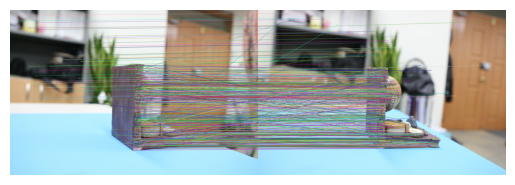

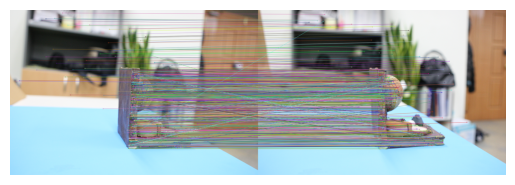

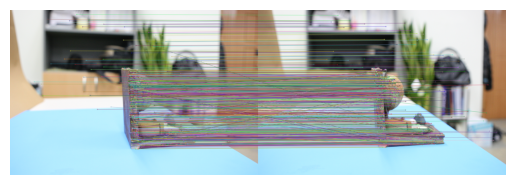

In [4]:
# Plot matches
for i in range(3):
    img_i = cv2.drawMatches(
        images[i],
        keypoints[i],
        images[i + 1],
        keypoints[i + 1],
        matches[(i, i + 1)],
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    )

    plt.imshow(img_i)
    plt.axis("off")
    plt.show()

## Step 2: Eliminate Outliers


In [5]:
# Remove outliers from matches using cv2.findHomography

for i, j in matches.keys():
    kp1 = np.array([keypoints[i][m.queryIdx].pt for m in matches[(i, j)]])
    kp2 = np.array([keypoints[j][m.trainIdx].pt for m in matches[(i, j)]])

    H, mask = cv2.findHomography(kp1, kp2, cv2.RANSAC, 5.0)

    matches[(i, j)] = [m for m, msk in zip(matches[(i, j)], mask) if msk]

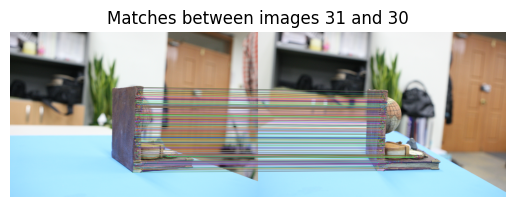

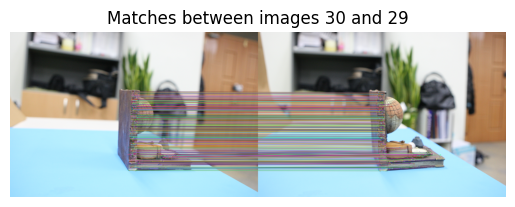

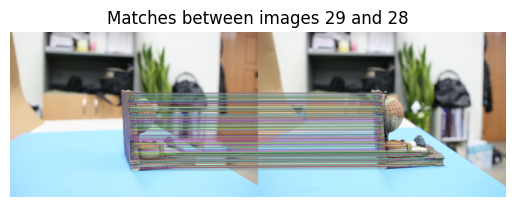

In [6]:
# Plot matches
for i in range(3):
    img_i = cv2.drawMatches(
        images[i],
        keypoints[i],
        images[i + 1],
        keypoints[i + 1],
        matches[(i, i + 1)],
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    )

    plt.title(
        f"Matches between images {get_original_image_id(i)} and {get_original_image_id(i + 1)}"
    )
    plt.imshow(img_i)
    plt.axis("off")
    plt.show()

## Step 3: Essential Matrix Estimation


In [7]:
# Find the best image pair (with the most matches)
best_pair_idx = np.argmax([len(m) for m in matches.values()])
best_matches = list(matches.items())[best_pair_idx][1]

print(f"Number of matches in best pair: {len(best_matches)}")
best_pair_i, best_pair_j = list(matches.keys())[best_pair_idx]
print(
    f"Best pair: ({get_original_image_id(best_pair_i)}, {get_original_image_id(best_pair_j)})"
)

# Get points from matches
pts1 = np.float32([keypoints[best_pair_i][m.queryIdx].pt for m in best_matches])
pts2 = np.float32([keypoints[best_pair_j][m.trainIdx].pt for m in best_matches])

# Compute the essential matrix
K = np.array(
    [
        [1698.873755, 0.000000, 971.7497705],
        [0.000000, 1698.8796645, 647.7488275],
        [0.000000, 0.000000, 1.000000],
    ]
)
E, mask = cv2.findEssentialMat(
    pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=5.0
)

Number of matches in best pair: 1208
Best pair: (26, 25)


In [8]:
num_outliers = np.sum(mask == 0)
print(f"Number of outliers: {num_outliers}")

num_inliers = np.sum(mask == 1)
print(f"Number of inliers: {num_inliers}")

Number of outliers: 0
Number of inliers: 1208


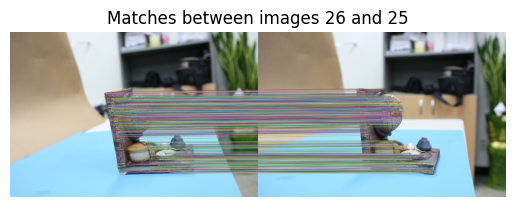

In [9]:
# Plot the best pair of images
img_best_pair = cv2.drawMatches(
    images[best_pair_i],
    keypoints[best_pair_i],
    images[best_pair_j],
    keypoints[best_pair_j],
    best_matches,
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)

plt.title(
    f"Matches between images {get_original_image_id(best_pair_i)} and {get_original_image_id(best_pair_j)}"
)
plt.imshow(img_best_pair)
plt.axis("off")
plt.show()

## Step 4: Camera Pose Estimation


In [10]:
R1, R2, t = cv2.decomposeEssentialMat(E)

# Select the correct rotation and translation
P1 = np.hstack((np.eye(3), np.zeros((3, 1))))  # First camera at (I|0)
P2s = [
    np.hstack((R1, t)),
    np.hstack((R1, -t)),
    np.hstack((R2, t)),
    np.hstack((R2, -t)),
]


def count_positive_depth(P1, P2, pts1, pts2, K):
    """Count the number of triangulated points with positive depth in both camera frames"""
    points_4d = cv2.triangulatePoints(K @ P1, K @ P2, pts1.T, pts2.T)
    points_3d = (
        points_4d[:3] / points_4d[3]
    )  # Convert to 3D by dividing by homogeneous coord

    # Convert to second camera's coordinate system
    points_cam2 = P2[:, :3] @ points_3d + P2[:, 3].reshape(3, 1)

    # Count points where Z > 0 in both camera frames
    return np.sum((points_3d[2] > 0) & (points_cam2[2] > 0))


# Select the best P2 based on positive depth count
P2 = max(P2s, key=lambda P2_i: count_positive_depth(P1, P2_i, pts1, pts2, K))

print("R:", P2[:, :3])
print("t:", P2[:, 3])

R: [[ 0.99362862 -0.09872738  0.0543605 ]
 [ 0.0979837   0.99505638  0.01618632]
 [-0.05568979 -0.01075675  0.99839017]]
t: [-0.72815252 -0.37030894  0.57677135]


In [11]:
# Double check the results
_, R_, t_, mask = cv2.recoverPose(E, pts1, pts2, K)
print("R_:", R_)
print("t_:", t_.reshape(-1))

print(f"{np.allclose(R_, P2[:, :3])=}")
print(f"{np.allclose(t_.reshape(-1), P2[:, 3])=}")

R_: [[ 0.99362862 -0.09872738  0.0543605 ]
 [ 0.0979837   0.99505638  0.01618632]
 [-0.05568979 -0.01075675  0.99839017]]
t_: [-0.72815252 -0.37030894  0.57677135]
np.allclose(R_, P2[:, :3])=True
np.allclose(t_.reshape(-1), P2[:, 3])=True


In [12]:
# Reconstruct 3D points using cv2.triangulatePoints
points = cv2.triangulatePoints(K @ P1, K @ P2, pts1.T, pts2.T)
points /= points[3]

In [13]:
import open3d as o3d

cloud = o3d.geometry.PointCloud()
cloud.points = o3d.utility.Vector3dVector(points.T[:, :3])

o3d.io.write_point_cloud(f"{data_out}/{data_set}-2.ply", cloud)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


True

# Step 5: Growing step


In [ ]:
# # Sort matches (and keys) by number of matches
# best_pairs = sorted(matches.items(), key=lambda item: len(item[1]), reverse=True)

# K = np.array(
#     [
#         [1698.873755, 0.000000, 971.7497705],
#         [0.000000, 1698.8796645, 647.7488275],
#         [0.000000, 0.000000, 1.000000],
#     ]
# )
# for k_, ((i, j), m) in enumerate(best_pairs):
#     if k_ == 0:
#         continue

#     # Get points from matches
#     pts1 = np.float32([keypoints[i][m.queryIdx].pt for m in matches[(i, j)]])
#     pts2 = np.float32([keypoints[j][m.trainIdx].pt for m in matches[(i, j)]])

#     # Compute the essential matrix
#     E, mask = cv2.findEssentialMat(
#         pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0
#     )

#     # Estimate P matrix using solvePnP with best_keys
#     _, R, t, mask = cv2.recoverPose(E, pts1, pts2, K)

#     # Triangulate points
#     P2 = np.hstack((R, t))
#     points = cv2.triangulatePoints(K @ P1, K @ P2, pts1.T, pts2.T)
#     points /= points[3]

#     # Add new points to the point cloud
#     cloud.points = o3d.utility.Vector3dVector(
#         np.vstack((cloud.points, points.T[:, :3]))
#     )

#     # Save point cloud
#     o3d.io.write_point_cloud(f"{data_out}/{data_set}-{k_ + 2}.ply", cloud)